## Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from operator import itemgetter 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import random
import copy

In [7]:
data = pd.read_csv('titanic_dataset.csv', header = 0)
#data.drop('PassengerId', axis = 1, inplace = True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [8]:
df = copy.deepcopy(data)

In [9]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

In [10]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations (choose the observation using active learning approach) from **df** to your trainset, refit the model and evaluate on test_df again
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

# Data cleaning

In [11]:
clean_data = copy.deepcopy(start_df)

In [12]:
def clean(data):
    new_data = copy.deepcopy(data)
    new_data.drop(['PassengerId','Name','Ticket','Cabin'], axis =1, inplace = True)
    new_data['Age'].fillna(np.mean(new_data['Age']), inplace = True)
    new_data['Age'].fillna(new_data['Embarked'].mode()[0], inplace = True)
    le = LabelEncoder()
    new_data['Sex'] = le.fit_transform(new_data['Sex'])
    new_data['Embarked'] = le.fit_transform(new_data['Embarked'].astype(str))
    num_feats = new_data[['Age','Fare']]
    scaled = StandardScaler().fit_transform(num_feats)
    new_data['Age'] = scaled[:,0]
    new_data['Fare'] = scaled[:,1]
    return(new_data)

In [13]:
# temp = clean(df)
# temp = temp.astype({'Sex':int, 'Embarked':int})
# temp.dtypes

In [14]:
# total = clean_data.isnull().sum().sort_values(ascending = False)
# p = (clean_data.isnull().sum()/clean_data.shape[0]).sort_values(ascending = False)
# sum_table = pd.concat([total,p], axis = 1, keys=['total','percentage'])
# sum_table

# 1)

In [15]:
clean_data = clean(clean_data)

In [16]:
clean_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
288,1,2,1,7.659854e-01,0,0,-0.290060,2
42,0,3,1,4.993840e-16,0,0,-0.368456,0
416,1,2,0,2.037290e-01,1,1,0.009442,2
329,1,1,0,-1.061348e+00,0,1,0.400779,0
587,1,1,1,2.031062e+00,1,1,0.726711,0
...,...,...,...,...,...,...,...,...
10,1,3,0,-1.904733e+00,1,1,-0.233231,2
173,0,3,1,-7.099377e-01,0,0,-0.368007,2
431,1,3,0,4.993840e-16,1,0,-0.242447,2
592,0,3,1,1.117396e+00,0,0,-0.378375,2


In [17]:
X = clean_data.drop('Survived', axis = 1)
y = clean_data['Survived']

In [18]:
svc = SVC(probability = True)
svc.fit(X,y)

SVC(probability=True)

In [19]:
y_pred = svc.predict((clean(test_df).drop(['Survived'],axis = 1)))
y_proba = svc.predict_proba((clean(test_df).drop(['Survived'],axis = 1)))
y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [20]:
min(y_proba[0])

0.22490684206510278

In [21]:
print(accuracy_score(test_df['Survived'],y_pred))
print(recall_score(test_df['Survived'],y_pred))
print(precision_score(test_df['Survived'],y_pred))

0.81
0.75
0.7692307692307693


In [611]:
# temp_preds = svc.predict_proba((clean(df).drop(['Survived'],axis = 1)))
# temp_preds

# margin_sample = abs(temp_preds[:,0] - temp_preds[:,1])
# margin_sample

# list(margin_sample.argsort()[:10])

# to_get = list(itemgetter(*list(margin_sample.argsort()[:10]))(df.index.values.tolist()))
# to_get

# df.loc[to_get,:]

# pd.concat([clean_data,clean(df.loc[to_get,:])])

# df.drop(to_get)

### Active Learning

In [137]:
data = pd.read_csv('titanic_dataset.csv', header = 0)
df = copy.deepcopy(data)
test_df = df.sample(n=100, random_state=42)
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]
start_df = df.sample(n=100, random_state=42)
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [138]:
clean_data = copy.deepcopy(start_df)

In [139]:
clean_data = clean(clean_data)

In [140]:
clean_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
288,1,2,1,7.659854e-01,0,0,-0.290060,2
42,0,3,1,4.993840e-16,0,0,-0.368456,0
416,1,2,0,2.037290e-01,1,1,0.009442,2
329,1,1,0,-1.061348e+00,0,1,0.400779,0
587,1,1,1,2.031062e+00,1,1,0.726711,0
...,...,...,...,...,...,...,...,...
10,1,3,0,-1.904733e+00,1,1,-0.233231,2
173,0,3,1,-7.099377e-01,0,0,-0.368007,2
431,1,3,0,4.993840e-16,1,0,-0.242447,2
592,0,3,1,1.117396e+00,0,0,-0.378375,2


In [46]:
temp_preds = svc.predict_proba((clean(df).drop(['Survived'],axis = 1)))
margin_sample = abs(temp_preds[:,0] - temp_preds[:,1])
to_get = list(itemgetter(*list(margin_sample.argsort()[:5]))(df.index.values.tolist()))

In [123]:
margin_sample=np.array([0,3,7,23,8,1,8,2,1,8,3])
to_get = list(itemgetter(*list(margin_sample.argsort()[:5]))(df.index.values.tolist()))

In [124]:
to_get

[0, 5, 8, 7, 1]

In [125]:
idx = list(np.argpartition(margin_sample, 5)[:5])
idx

[8, 0, 5, 7, 1]

In [106]:
idx[:5]

array([8, 0, 5, 7, 1])

In [93]:
np.array(margin_sample[idx[:5]])

array([1, 0, 1, 2, 3])

In [135]:
clean(df.iloc[[175, 281, 647, 65, 527],:])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
224,1,1,1,0.075122,1,0,0.999825,1
370,1,1,1,-0.901466,1,0,-0.309180,0
829,1,1,0,1.878054,0,0,0.621043,2
85,1,3,0,-0.300489,3,0,-1.808840,1
681,1,1,1,-0.751222,0,0,0.497152,0


In [136]:
df.iloc[175]

PassengerId                             225
Survived                                  1
Pclass                                    1
Name           Hoyt, Mr. Frederick Maxfield
Sex                                    male
Age                                      38
SibSp                                     1
Parch                                     0
Ticket                                19943
Fare                                     90
Cabin                                   C93
Embarked                                  S
Name: 224, dtype: object

In [143]:
iterations = 10
batch = 10
metrics = []
svc = SVC(probability = True)

In [145]:
for i in range(iterations):
    X = clean_data.drop('Survived', axis = 1)
    y = clean_data['Survived']
    svc.fit(X,y)
    y_pred = svc.predict((clean(test_df).drop(['Survived'],axis = 1)))
    acc = accuracy_score(test_df['Survived'],y_pred)
    recall = recall_score(test_df['Survived'],y_pred)
    precision = precision_score(test_df['Survived'],y_pred)
    met = [acc,recall,precision]
    metrics.append(met)
    
    temp_preds = svc.predict_proba((clean(df).drop(['Survived'],axis = 1)))
    margin_sample = abs(temp_preds[:,0] - temp_preds[:,1])
    to_get = list(itemgetter(*list(margin_sample.argsort()[:batch]))(df.index.values.tolist()))
    #to_get = list(np.argpartition(margin_sample, 5)[:5])
    #print(to_get)
    clean_data = pd.concat([clean_data,clean(df.loc[to_get,:])])
    
    df.drop(to_get, inplace = True)

[11, 340, 839, 665, 193, 829, 831, 64, 655, 745]
[858, 209, 817, 788, 248, 125, 183, 599, 863, 180]
[529, 374, 124, 167, 450, 308, 224, 748, 348, 229]
[622, 245, 96, 487, 135, 262, 751, 647, 489, 145]
[632, 583, 731, 452, 604, 54, 38, 155, 766, 147]
[869, 102, 377, 352, 275, 505, 366, 195, 177, 258]
[737, 550, 879, 544, 373, 549, 268, 453, 754, 332]
[660, 645, 856, 685, 27, 888, 484, 698, 779, 600]
[341, 533, 726, 789, 34, 305, 139, 62, 255, 140]
[736, 85, 175, 567, 741, 681, 15, 336, 618, 424]


In [146]:
#metrics

In [147]:
temp = pd.DataFrame(metrics)
temp = temp.rename(columns={0: 'accuracy',1:'recall',2:'precision'})
temp.head()

,accuracy,recall,precision
0,0.81,0.775,0.756098
1,0.81,0.775,0.756098
2,0.79,0.775,0.720930
3,0.77,0.800,0.680851
4,0.78,0.800,0.695652


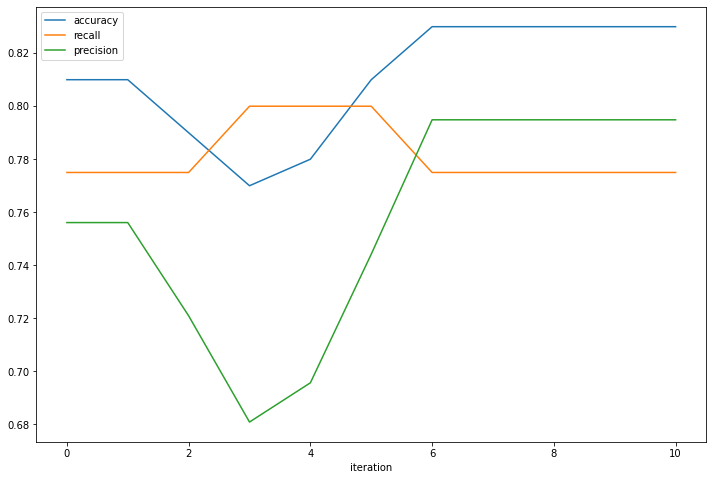

In [148]:
fig, ax = plt.subplots(figsize=(12,8))
temp.accuracy.plot(legend=True)
temp.recall.plot(legend=True) 
temp.precision.plot(legend=True)
plt.xlabel('iteration')
plt.show()